# Project Stage 2: Data Analysis

- ** INFO1903 **
- ** Rahul Vemulapally **
- ** SID - 440317463 **

### Instructions to run this notebook

**Install if not already installed:**

    - jupyter      - pip3 install jupyter
    - sqlalchemy   - pip3 install sqlalchemy --user unix_username
    - psycopg2     - pip3 install psycopg2 --user unix_username
    - ipywidgets   
        - pip3 install ipywidgets --user unix_username
        - jupyter nbextension enable --py  widgetsnbextension
    - nbconvert    - pip3 install nbconvert

    
- ipywidgets are needed for interactivity.
- sqlalchemy and psycopg2 are needed to interface with the postgres database
- nbconvert is needed to convert the notebook to HTML or Markdown, it uses pandoc (apt-get install pandoc)
    - eg:  jupyter nbconvert stage2d.ipynb --to html
    
**Change the postgres database connection variables** (it's around 7 cells further down the page)

##### Aim

The aim of this stage is to rank the LGAs (Local Government Area) based on the reported crimes in NSW.

##### Data Sets

Stage one cleaned the reported crimes data that was provided by NSW Bureau of Crime Statistics and Research (BOCSAR). 
** [Data Source: www.bocsar.nsw.gov.au](http://www.bocsar.nsw.gov.au/Documents/RCS-Annual/RCI_offencebymonth.zip) **
Or **[Original Data](source_files/RCI_offencebymonth.xlsm)**

    - The original data was from Jan,1995 - Dec,2016; for a total of 264 periods. 
    - Monthly counts were added together for each year, to give 22 periods of data (1995 - 2016). 
    - Original data had 62 different categories/sub-categories, these were grouped into 11 main categories.
        - The 11 main Categories are:

| Main Categories                   |
|-----------------------------------|
| Homicide                          |
| Assault                           |
| Sexual offences                   |
| Other offences against the person |
| Robbery                           |
| Property Offences                 |
| Drug Possession                   |
| Drug Dealing                      |
| Vice                              |
| Weapons offences                  |
| Other offences                    |

To see how the 62 categories were grouped into these 11 main categories, please see ** [offence_categories.xlsx](offence_categories.xlsx) **.
         
The cleaned data is in the file  ** [NSWcrimes.csv](NSWcrimes.csv) **, it lists the reported crimes for 62 different categories/sub-categories for the years 1995-2016. The category and Subcategory are in two different fields, when processing the file NSWcrimes.csv, these are concatenatee together to get the 62 categories. 


**Two more data sets were used in this analysis:**

- **Popultaion Counts for each LGA:**
        - This data was obtained from ABS 2011 census by building the following table:
            - 2011 Census of Population and Housing - TableBuilder Basic
                - 2011 Census - Persons and Relationships
                    - Table: LGA by GCCSA
                        - LGA: Local Government Areas (2011 Boundaries) > New South Wales > LGA
                        - GCCSA: Greater Capital City Statistical Areas (UR) > New South Wales > GCCSA
                        - This table lists the "Persons' Place of Usual Residence"
    
   - This data is stored in ** [LGApop2011.xlsx](source_files/LGApop2011.xlsx)  **
   - The total population counts for each LGA were taken and saved to ** [2011LGA_pop.csv](2011LGA_pop.csv) **
   
           
- **Rents dataset:**
    - Holds the rents for 1,2,3,4+ bedroom dwellings for each LGA in GMR (Greater Metropolitan Regions, i.e., most of Greater Sydney and some regional cities), ** [Source: www.housing.nsw.gov.au](http://www.housing.nsw.gov.au/__data/assets/excel_doc/0003/408828/Rent_Report_16q4.xls) **.
    - Cleaned and saved the data in "lga_ad" tab from the original file to ** [rents_gmr.csv](rents_gmr.csv) **.

- **[lga.txt](lga.txt) :** holds the names of all 152 LGAs plus (Unincorporated Far West, Lord Howe Island, Prisons)

### Two methods were used in the analysis.

** Before we proceed further it is important to note that Sydney LGA has the highest aggregate crimes reported, this is charecteristic of any area that has a high transient population (visitors).  To make any meaningful comparisions we will have to add this transient population to the resident population but deciding on an appropriate number for the transient population is very subjective and choosing a large number will significantly improve Sydney's ranking! **


#####  Method -1

Done using absolute counts and also counts adjusted for population in each LGA:

    -  Used 2011 Census population counts (for each LGA) throughout the analysis, it would have been appropriate to use Census data from different years to improve accuracy but due to time constraints I will be using 2011 population counts for all 22 years of data. 
    - Adjusted counts are for every 10000 people in that LGA and calculated as: 
    
$$\left[\frac{\text{LGA's aggregate for each Year}}{\text{2011 population for the corresponding LGA}} \right] * 10000$$

###### Psudocode
- For each LGA:
    - For each Year:
        - Add all the crimes reported (i.e., add all categories' counts for each year)
        - Rank the LGA's from lowest to highest counts ** (Table 1 in the below illustration) **
    - This should give 22 ranks (if all 22 Years selected) for each LGA 
    - Take the mean/median of these ranks to get the overall rank for each LGA   ** (Table 2 in the below illustration) **
      
**An illustration of ranking population adjusted counts**
![Ranking](m1ranks.png)


This method treats all crimes with equal weightage, which is erroneous! 


Method-2 corrects this by ranking LGA's separately for each category  and taking the mean rank over all the categories to get the overall rank.


##### Method-2

 - Only used the population adjusted counts.

###### Psudocode
- For each Category:
    - For each Year:
        - Rank the LGA's from lowest to highest counts
    - This should give 22 ranks (if all 22 Years selected) for each LGA  (**Table A** in the below illustration)
    - Take the mean of these ranks to get the overall rank for each LGA for that Category (**e.g: In the below Final Table, Assault row ranks are the means from Table A**)
- This should give 11 ranks (If all 11 categories selected) for each LGA
- Take the mean of these 11 ranks to get an overall rank for each LGA.

**An illustration of calculating the ranks for each Category under Method-2**
![CategoryRanks](m2ranks.png)


##### NOTE - when running this notebook if a cell shows " In [*]:", it means the cell is being processed. Please wait until a number is shown in the [ ] (e.g: In [77]:)


### Modules used in the Notebook

In [ ]:
%matplotlib notebook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import collections
# USED FOR DEEP COPY INSTEAD OF SHALLOW COPY OF DICTIONARIES
import copy
# FOR INTERACTIVITY
from ipywidgets import *
from IPython.display import *
# TO INTERFACE WITH POSTGRES DATABASE
from sqlalchemy import *
import psycopg2

#### POSTGRES database settings

** Change the below values to connect to the database server. **

In [ ]:
# CREATE A CONNECTION TO THE POSTGRES DATABASE USING sqlAlchemy

PORT = "5432"          # this is the default PG port
LOGIN = "postgres"        # this is the user that has access to the database
PASSWORD = "password"      # user password
SERVER = "localhost"       # server where the database is located
DATABASE = "proj1903"      # database name

#create engine:
engine = create_engine('postgresql://{LOGIN}:{PASSWORD}@{SERVER}:{PORT}/{DATABASE}'.format(LOGIN=LOGIN, 
                                              PASSWORD=PASSWORD, SERVER=SERVER, PORT=PORT, DATABASE=DATABASE))


In [1]:
#some of these variables will be used several times in the notebook:

# lga - HOLDS THE NAMES OF ALL 152 LGA PLUS (Unincorporated Far West, Lord Howe Island, Prisons)

with open('lga.txt') as f:                
    lga = f.read().splitlines()
    
    
yrs = ['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', 
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']


# off_cat - THE BELOW DICTIONARY OF DICTIONARIES IS USED IN PROCESSESING THE DATA IN THE FILE NSWcrimes.csv
# IT ALLOWS GROUPING OF 62 DIFFERENT CATEGORIES INTO THE 11 MAIN GROUPS

off_cat = {'Homicide' :['Homicide(Murder *)', 'Homicide(Attempted murder)', 'Homicide(Murder accessory, conspiracy)', 'Homicide(Manslaughter *)'],
'Assault' : ['Assault(Domestic violence related assault)', 'Assault(Non-domestic violence related assault)', 'Assault(Assault Police)'],
'Sexual offences' : [ 'Sexual offences(Sexual assault)', 'Sexual offences(Indecent assault, act of indecency and other sexual offences)'],
'Other offences against the person' : ['Harassment, threatening behaviour and private nuisance(None)', 'Blackmail and extortion(None)', 'Abduction and kidnapping(None)', 'Other offences against the person(None)'],
'Robbery' : ['Robbery(Robbery without a weapon)', 'Robbery(Robbery with a firearm)', 'Robbery(Robbery with a weapon not a firearm)'],
'Property offences' : ['Theft(Break and enter dwelling)', 'Theft(Break and enter non-dwelling)', 'Theft(Receiving or handling stolen goods)', 'Theft(Motor vehicle theft)', 'Theft(Steal from motor vehicle)', 'Theft(Steal from retail store)', 'Theft(Steal from dwelling)', 'Theft(Steal from person)', 'Theft(Stock theft)', 'Theft(Fraud)', 'Theft(Other theft)', 'Arson(None)', 'Malicious damage to property(None)'],
'Drug Possession' : ['Drug offences(Possession and/or use of cocaine)', 'Drug offences(Possession and/or use of narcotics)', 'Drug offences(Possession and/or use of cannabis)', 'Drug offences(Possession and/or use of amphetamines)', 'Drug offences(Possession and/or use of ecstasy)', 'Drug offences(Possession and/or use of other drugs)'],
'Drug Dealing' : ['Drug offences(Dealing, trafficking in cocaine)', 'Drug offences(Dealing, trafficking in narcotics)', 'Drug offences(Dealing, trafficking in cannabis)', 'Drug offences(Dealing, trafficking in amphetamines)', 'Drug offences(Dealing, trafficking in ecstasy)', 'Drug offences(Dealing, trafficking in other drugs)', 'Drug offences(Cultivating cannabis)', 'Drug offences(Manufacture drug)', 'Drug offences(Importing drugs)', 'Drug offences(Other drug offences)'],
'Vice' : ['Betting and gaming offences(None)', 'Liquor offences(None)', 'Pornography offences(None)', 'Prostitution offences(None)'],
'Weapons offences': ['Prohibited and regulated weapons offences(None)'],
'Other offences' : ['Against justice procedures(Escape custody)', 'Against justice procedures(Breach Apprehended Violence Order)', 'Against justice procedures(Breach bail conditions)', 'Against justice procedures(Fail to appear)', 'Against justice procedures(Resist or hinder officer)', 'Against justice procedures(Other offences against justice procedures)', 'Transport regulatory offences(None)', 'Other offences(None)', 'Disorderly conduct(Trespass)', 'Disorderly conduct(Offensive conduct)', 'Disorderly conduct(Offensive language)', 'Disorderly conduct(Criminal intent)']}

# cats -  THESE ARE THE 11 MAIN CATEGORIES

cats = ['Homicide', 'Assault', 'Sexual offences', 'Other offences against the person', 'Robbery', 
        'Property offences', 'Drug Possession', 'Drug Dealing', 'Vice', 'Weapons offences', 'Other offences']

# gsyd - THESE ARE THE GREATEER SYDNEY LGAs

gsyd = ['Ashfield', 'Auburn', 'Bankstown', 'Blacktown', 'Blue Mountains', 'Botany Bay', 'Burwood', 'Camden', 'Campbelltown', 'Canada Bay', 
        'Canterbury', 'Fairfield', 'Gosford', 'Hawkesbury', 'Holroyd', 'Hornsby', 'Hunters Hill', 'Hurstville', 'Kogarah', 'Ku-ring-gai', 'Lane Cove', 'Leichhardt', 'Liverpool',
        'Manly', 'Marrickville', 'Mosman', 'North Sydney', 'Parramatta', 'Penrith', 'Pittwater', 'Randwick', 'Rockdale', 'Ryde', 'Strathfield', 'Sutherland Shire', 'Sydney', 
        'The Hills Shire', 'Warringah', 'Waverley', 'Willoughby', 'Wollondilly', 'Woollahra', 'Wyong']

# regnsw -  THESE ARE THE REGIONAL LGAs

regnsw = ['Albury', 'Armidale Dumaresq', 'Ballina', 'Balranald', 'Bathurst Regional', 'Bega Valley', 'Bellingen', 
           'Berrigan', 'Bland', 'Blayney', 'Bogan', 'Bombala', 'Boorowa', 'Bourke', 'Brewarrina', 'Broken Hill', 
           'Byron', 'Cabonne', 'Carrathool', 'Central Darling', 'Cessnock', 'Clarence Valley', 'Cobar', 'Coffs Harbour', 
           'Conargo', 'Coolamon', 'Cooma-Monaro', 'Coonamble', 'Cootamundra', 'Corowa Shire', 'Cowra', 'Deniliquin', 
           'Dubbo', 'Dungog', 'Eurobodalla', 'Forbes', 'Gilgandra', 'Glen Innes Severn', 'Gloucester', 'Goulburn Mulwaree', 
           'Great Lakes', 'Greater Hume Shire', 'Greater Taree', 'Griffith', 'Gundagai', 'Gunnedah', 'Guyra', 
           'Gwydir', 'Harden', 'Hay', 'Inverell', 'Jerilderie', 'Junee', 'Kempsey', 'Kiama', 'Kyogle', 'Lachlan',
           'Lake Macquarie', 'Leeton', 'Lismore', 'Lithgow', 'Liverpool Plains', 'Lockhart', 'Maitland', 
           'Mid-Western Regional', 'Moree Plains', 'Murray', 'Murrumbidgee', 'Muswellbrook', 'Nambucca', 
           'Narrabri', 'Narrandera', 'Narromine', 'Newcastle', 'Oberon', 'Orange', 'Palerang', 'Parkes', 
           'Port Macquarie-Hastings', 'Port Stephens', 'Queanbeyan', 'Richmond Valley', 'Shellharbour', 
           'Shoalhaven', 'Singleton', 'Snowy River', 'Tamworth Regional', 'Temora', 'Tenterfield', 'Tumbarumba', 
           'Tumut Shire', 'Tweed', 'Upper Hunter Shire', 'Upper Lachlan Shire', 'Uralla', 'Urana', 
           'Wagga Wagga', 'Wakool', 'Walcha', 'Walgett', 'Warren', 'Warrumbungle Shire', 'Weddin',
           'Wellington', 'Wentworth', 'Wingecarribee', 'Wollongong', 'Yass Valley', 'Young', 'Unincorporated Far West']


## Loading the data

### Processing the data in NSWcrimes.csv

The idea is to store stats for each year in an SQL table. 
    - i.e, each table has:
        - 156 Attributes/Columns - 152 LGAs PLUS (Unincorporated Far West, Lord Howe Island, Prisons) and
        - 11 Tuples/Rows  - 11 main categories

The data in NSWcrimes.csv has 64 categories/sub-categories, which will be reduced to the 11 main categories.

** psudocode **

- setup a defaultdict collection object template  (temp_yr) that holds dictionaries and initialise it with LGA names as keys
- Define two more defaultdict collection objects to be used in the loop
- For each year:
    - open NSWcrimes.csv file using csv.dictreader
    - initaialise a defaultdict object to hold the stats without grouping (i.e, for 62 categories), keys are LGAs    
    - iterate over the reader dict object and save the stats to the dict of dicts (subs1)
    - initaialise another defaultdict object to hold the grouped stats (subs_yr)
    - iterate over the subs1 dictionary and group the categories into 11 main categories
    - create a Pandas Dataframe form this final dictionary of dictionaries object (subs_yr)
    - write the dataframe to a SQL table

** Data was validated by comparing with the stats from the file [RCI_offencebyyear.xlsx](RCI_offencebyyear.xlsx). **

In [2]:
# CREATE SOME defaultdict collection objects

subs1 = collections.defaultdict(dict)
subs_yr = collections.defaultdict(dict)
temp_yr = collections.defaultdict(dict)

for i in lga:
     temp_yr[i] = {}             # template to hold all subs as a dict of dictS


# the below code does:
        # for each year, open the file and save all the stats for each year into a dict of dict for that year (subs1)
        # then iterate over susb1 and group the crime categories into subs_yr

for yr in yrs:
        # Below code:  we need to open the file inside the loop otherwise once it goes through the robj iterator once it will have tobe reset, (read that it is very memory intensive)
        # having it inside the loop it resets every time the file opens.

    with open('NSWcrimes.csv') as fin:                            # open the file
        robj = csv.DictReader(fin, delimiter=';')            # using csv.DictReader to read the file, returns a reader object

                                            # making a deep copy instead of shallow copy, resets for each year
        subs1 = copy.deepcopy(temp_yr)           # to hold each subs stats without grouping

        for b in robj:                   # this makes the offences+sub-categories into one key
            temp = b['Offence category']+ '('+b['Subcategory']+')'
            subs1[b['LGA']][temp] = b[yr]

        subs_yr = copy.deepcopy(temp_yr)     #  this dict collection holds stats that are grouped

        for c in subs1:                  # this groups together the categories to just 11 for yeach year
            for o in off_cat:
                  for n in off_cat[o]:
                    if o in subs_yr[c]:
                        subs_yr[c][o] += int(subs1[c][n])
                    else:
                        subs_yr[c][o] = int(subs1[c][n])

              # below code exports each dataframe as a table to postgres DB
                # each table corresponds to a particular year

        df1 = pd.DataFrame(subs_yr, index = cats)[lga]

        TABLE = 'y'+yr              # table name to be used when creating the table in POSTGRES DB
        
        # ONLY NEED TO RUN THE BELOW ONCE
        
        #df1.to_sql(TABLE, engine, index_label='Categories')

NameError: name 'collections' is not defined

** This is how the transformed data that is stored in the POSTGRES database looks like **

** Select the Year from the dropdown list to pull up the stats for that year. **

In [11]:
def yrf(Year):
    yr1 = 'y'+Year
    dy4 = pd.read_sql_table(yr1,engine)
    return(dy4)
interact(yrf,Year=yrs)

<function __main__.yrf>

### Loading LGA populations (from Year 2011 census) into a table in POSTGRES database

In [13]:
with open('2011LGA_pop.csv') as fpop:
    rin = csv.DictReader(fpop)
    pop1 = pd.DataFrame(next(rin), index = ['y2011POP'])         # there is only one line of data in the csv file

# ONLY NEED TO RUN THE BELOW LINE ONCE
#pop1.to_sql('pop', engine, index_label='Population')        # table name is 'pop'


### Sample output from the POSTGRES database:
proj1903b=# select "Population", "Sydney", "Ashfield", "Randwick" from pop;

| Population | Sydney | Ashfield | Randwick |
|:-----------|:-------|:---------|:---------|
| y2011POP   | 169507 | 41213    | 128988   |
|(1 row)     |


List of LGA's in the population dataframe also includes "No Usual Address". Removing it to give a list of 153 LGAs. 
Where as "lga" has 155 entries, the two missing ones are "Prisions" and "Lord Howe Island".

In [14]:
plga = list(pop1.columns)
plga.remove("No Usual Address")

### Loading the rents data  for "Greater Metropolitan Regions NSW" into an SQL table


In [16]:
rent = pd.read_csv('rents_gmr.csv', na_values = 'NULL', index_col='beds')

# ONLY NEED TO RUN THE BELOW ONCE
#rent.to_sql('rent', engine, index_label='beds')

## Exploring the Data

### Exploring stats for the selected LGAs and the Year

- Default selection for LGAs: Hunters Hill, Blacktown, Ku-ring-gai, Lane Cove, Leichhardt, Sydney

- Default Year: 2016

** Click on "Run Interact" after making the selection **

In [18]:
sel01 = widgets.SelectMultiple(
    options=plga,
    value=['Hunters Hill', 'Blacktown', 'Ku-ring-gai', 'Lane Cove', 'Leichhardt', 'Sydney'],
    description='LGA:',
    disabled=False,
    layout=Layout(display="inline_flex", flex_flow='column')
)

yer01  = widgets.Dropdown(
    options=yrs,
    value='2016',
    description='Year:',
    disabled=False,
    layout=Layout(width='20%')
)

def h01(s01, y01):
    global tab01
    y11 = 'y'+y01
    tab02 = pd.read_sql_table(y11,engine, index_col='Categories')
    tab01 = tab02[list(s01)]
    return(tab01)
interact_manual(h01,  y01=yer01, s01=sel01)

<function __main__.h01>

### Population adjusted counts, per 10000 people

** The below cell shows the population adjusted data for the above selected LGAs **

In [19]:
# Creating an array of population counts to match the dimensions of the output table above
# This array has 11 rows with same values for each LGA

pop01 = np.array(pop1[list(sel01.value)])
pop02 = np.tile(pop01, (11,1))
pdiv = pop02.astype('int')
tadj01 = (tab01*10000).div(pdiv, axis='columns').astype('int')
tadj01

,Hunters Hill,Blacktown,Ku-ring-gai,Lane Cove,Leichhardt,Sydney
Categories,,,,,,
Homicide,0,0,0,0,0,0
Assault,28,123,13,29,62,267
Sexual offences,8,18,7,4,7,32
Other offences against the person,21,66,8,16,32,69
Robbery,2,8,0,0,3,15
Property offences,201,520,170,185,389,1290
Drug Possession,26,45,8,14,24,431
Drug Dealing,3,8,3,1,5,103
Vice,4,7,0,0,6,177


### Below cell produces stacked bar plots of the absolute counts and the population adjusted counts. 

As mentioned earlier comparing Sydney with other LGAs is misleading.  It is clear in the below bar plot, even after adjusting for the resident populations, Sydney counts are way too high.

<IPython.core.display.Javascript object>


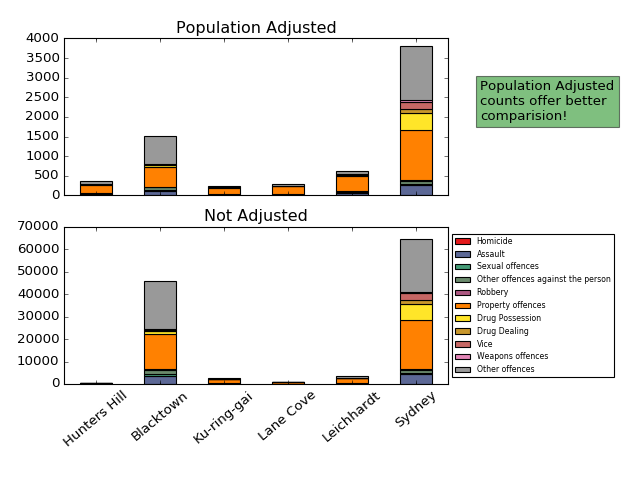

In [20]:
plt.ioff()
fig2a = plt.figure()

ax21 = fig2a.add_subplot(211)
ax22 = fig2a.add_subplot(212, sharex=ax21)
tadj01.T.plot.bar(stacked=True, ax=ax21, legend=False, title='Population Adjusted', colormap='Set1')
tab01.T.plot.bar(stacked=True, ax=ax22, legend=False, title='Not Adjusted', rot=40, colormap='Set1')
plt.subplots_adjust(top=0.92, bottom=0.2, left=0.10, right=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='xx-small')
plt.figtext(0.75,0.75,"Population Adjusted counts offer better comparision!", bbox=dict(facecolor='green', alpha=0.5), wrap=True)
#plt.savefig("comp.pdf", bbox_inches="tight")
plt.show()

### Exploring stats for a single LGA:

- Select:
    - Years (plot 1): 1995 - 2016  (Select all to see patterns) 
    - Categories (plot 2): In the first plot all Categories are selected, for the second plot drop some (eg, For Sydney, dropping "Property offences" and "Other offences" clearly shows increasing counts for "Drug Possession")   


In [21]:
# PLOT 1
sel = widgets.SelectMultiple(
    options=yrs,
    value=yrs,
    description='Year',
    disabled=False,
    layout=Layout(display="inline_flex", flex_flow='column', width='20%')
)
# THIS GIVES THE DATA FOR THE SELECTED YEARS FOR  A CHOSEN SUBURB AND THE STACKED BAR PLOT
def yh(Year, sub):
    global dy6
    t = 1
    for y in Year:
        yr1 = 'y'+y
        if t:
            query = 'SELECT \"Categories\", \"'+sub+'\" FROM '+ yr1+';'
            dy6 = pd.read_sql_query(query, engine,index_col="Categories")
            dy6.rename_axis({sub: sub+y}, axis="columns", inplace=True)
            t = 0
        else:
            query = 'SELECT \"Categories\", \"'+sub+'\" FROM '+ yr1+';'
            temp = pd.read_sql_query(query, engine,index_col="Categories")
            assert sub+y not in dy6
            dy6[sub+y]=temp[sub]
   
    # Stacked Bar chart
    # plt.ioff()
    fig4 = plt.figure()
    ax42 = fig4.add_axes([0.3, 0.2, 0.65, 0.7])
    dy6.T.plot.barh(ax=ax42, stacked=True,rot=20, fontsize = 8,legend=False, colormap='Set1')
    ax42.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize='xx-small')
    plt.show()
    return(dy6)
interact_manual(yh,Year=sel, sub=lga)


<function __main__.yh>

In [22]:
# PLOT 2
# KEEP ONLY THE CATEGORIES WE ARE INTERESTED IN

cat0 = widgets.SelectMultiple(
    options=cats,
    value=['Homicide', 'Assault', 'Sexual offences', 'Other offences against the person', 'Robbery', 'Drug Dealing', 'Weapons offences'],
    description='Categories',
    disabled=False,
    layout=Layout(display="inline_flex", flex_flow='column')
)
def fyh(cat):
    tempc = list(set(cats) - set(cat))
    dy6b= dy6.drop(tempc, axis=0)
    plt.ioff()
    fig5 = plt.figure()
    ax52 = fig5.add_axes([0.3, 0.2, 0.65, 0.7])
    dy6b.T.plot.barh(ax=ax52, stacked=True,rot=20, legend=False, colormap='Set1')
    ax52.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize='xx-small')
    return(plt.show())
interact_manual(fyh, cat=cat0)

<function __main__.fyh>

## Analysis

#### User Input for both Method-1 and Method-2 analysis
 
SELECT:

- LGAs: Whether ranking should be for all LGA's, Greater Sydney LGAs, or Regional LGA's (NOTE: Only "GreaterSydney" option shows the rents columns)
    
- YEARS: By default all years are selected (data will be restricted to the Years selected) 
    
- CATEGORIES: By default all categories are selected (ranking is based on the aggregate (of the selected categories) counts for each year)


#### Defining the variables for user input

In [24]:
yrs1 = widgets.SelectMultiple(
    options=yrs,
    value=yrs,
    description='Years',
    disabled=False,
    layout=Layout(display="flex", flex_flow='column')
)
cat01 = widgets.SelectMultiple(
    options=cats,
    value=cats,
    description='Categories',
    disabled=False,
    layout=Layout(display="inline_flex", flex_flow='column')
)

# Select whether the analysis should be run for all LGA's, Greater Sydney LGAs, or Regional LGA's
sel9 = {'All': plga, 'GreaterSydney': gsyd, 'RegionalNSW' : regnsw}

lga9 = widgets.Dropdown(
    options=['All', 'GreaterSydney', 'RegionalNSW'],
    value='All',
    description='LGAs:',
    disabled=False,
    #layout=Layout(display="flex", flex_flow='column')
    layout=Layout(width='20%')
)

def f51(lga51, yr51, cat51):
    return({'LGAs' : str(lga51), 'Years Selected' : str(yr51), 'Categories' : str(cat51)})
interact_manual(f51, lga51=lga9, yr51 = yrs1, cat51=cat01)

<function __main__.f51>

### Method-1 Analysis

In [25]:
# USER SELECTION VALUES
subs2 = sel9[lga9.value]     
c1 = cat01.value
yr1 = yrs1.value

# this creates an empty data frame to hold values
dsum = pd.DataFrame(index=yr1, columns=subs2)  
dadj = pd.DataFrame(index=yr1, columns=subs2)

# GET THE DATA FROM THE POSTGRES DATABASE BASED ON THE USER SELECTION

if len(c1) == 1:                 # IF ONLY ONE CATEGORY IS SELECTED
    c11 = str(list(c1)[0])
    for s1 in subs2:
        ps1 = int(pop1.loc['y2011POP',s1])
        for y1 in yr1:
            yr2 = 'y'+y1
            query = 'SELECT \"'+s1+'\" FROM '+ yr2+' WHERE "Categories" ='+"'"+c11+"';"
            temp = pd.read_sql_query(query, engine)
            dsum.loc[y1,s1]=temp[s1].sum()
            dadj.loc[y1,s1]=round(((temp[s1].sum())/ps1)*10000)  
else:
    c11 = str(c1)
    for s1 in subs2:
        ps1 = int(pop1.loc['y2011POP',s1])
        for y1 in yr1:
            yr2 = 'y'+y1
            query = 'SELECT \"'+s1+'\" FROM '+ yr2+' WHERE "Categories" IN'+c11+';'
            temp = pd.read_sql_query(query, engine)
            dsum.loc[y1,s1]=temp[s1].sum()
            dadj.loc[y1,s1]=round(((temp[s1].sum())/ps1)*10000)           # population adjusted per 10000 people


# RANKING BY MEDIAN AS WELL AS MEAN FOR BOTH ABSOLUTE COUNTS AND POPULATION ADJUSTED COUNTS

dsumr_med = dsum.rank(axis=1,method='max',ascending=True).median(axis=0).sort_values().to_frame()
dsumr_med.rename(columns={0:'sum_median_rank'}, inplace=True)
dsumr_men = dsum.rank(axis=1,method='max',ascending=True).mean(axis=0).sort_values().to_frame()
dsumr_men.rename(columns={0:'sum_mean_rank'}, inplace=True)
dadjr_med = dadj.rank(axis=1,method='max',ascending=True).median(axis=0).sort_values().to_frame()
dadjr_med.rename(columns={0:'adj_median_rank'}, inplace=True)
dadjr_men = dadj.rank(axis=1,method='max',ascending=True).mean(axis=0).sort_values().to_frame()
dadjr_men.rename(columns={0:'adj_mean_rank'}, inplace=True)

#  JOINING ALL 4 RANK TABLES
dranks = dsumr_med.join([dsumr_men, dadjr_med, dadjr_men])

# CRATING THE FINAL OUTPUT TABLE, IF GreaterSydney SELECTED, ONLY THEN RENTS COLUMNS ARE SHOWN
pgsyd = pop1.loc[:,subs2]
if subs2 == gsyd:
    rgsyd = rent.loc[:,gsyd]
    final = dranks.join([pop1.T,rgsyd.T])
else:
    final = dranks.join([pop1.T])

# ROUNDING OFF THE RANKS FOR PRESENTATION
final0 = final.round({'sum_median_rank' : 0, 'sum_mean_rank': 0, 'adj_median_rank': 0, 'adj_mean_rank': 0})
final1 = final0.astype({'sum_median_rank' : 'int64', 'sum_mean_rank': 'int64', 'adj_median_rank': 'int64', 'adj_mean_rank': 'int64'}, errors='ignore')


In [26]:
#dsum      # UNCOMMENT THIS TO SEE THE AGGREGATES FOR EACH LGA FOR EACH YEAR

In [27]:
#dadj       # UNCOMMENT THIS TO SEE THE POPULATION ADJUSTED AGGREGATES FOR EACH LGA FOR EACH YEAR

** Select one of the options to sort the output. By default it is sorted by mean ranks of the adjusted population counts. **
- **sum_median_rank:** Data is not population adjusted, and ranked by uisng the median rank
- **sum_mean_rank:**  Data is not population adjusted, and ranked by using the mean rank
- **adj_median_rank:**  Data is population adjusted, and ranked by using the median rank
- **adj_mean_rank:**   Data is population adjusted, and ranked by using the mean rank

In [28]:
ff1 = widgets.RadioButtons(
    options=['sum_median_rank', 'sum_mean_rank', 'adj_median_rank', 'adj_mean_rank'],
    value='adj_mean_rank',
    description='Sorting Order:',
    disabled=False
)
def fin20(ch20):
    return(final1.sort_values(ch20))
interact_manual(fin20, ch20=ff1)

<function __main__.fin20>

In [ ]:
# UNCOMMENT THE BELOW TO WRITE THE OUTPUT TO AN EXCEL FILE
#writer = pd.ExcelWriter('final3.xlsx')
#final1.to_excel(writer, 'Sheet1')

### Method-2

As illustrated at the start of the notebook, methedology is as follows:
    1. FOR EACH SUB-CATEGORY:
        1a.   RANK EACH LGA FOR EACH YEAR, WE GET 22 RANKS FOR EACH LGA (FOR ONE SUB-CATEGORY)
        1b.   TAKE THE MEAN OVER THE 22 YEARS' RANKS TO GET THE RANKING FOR THAT SUB-CATEGORY
    2. REPEAT ABOVE FOR EACH SUB-CATEGORY
    3. TO GET THE OVER ALL RANKINGS OF LGA'S TAKE THE MEAN OVER THE SUB-CATEGORIES FOR EACH LGA

- Also only using the population adjusted data


In [ ]:
# THIS CODE CHUNK TAKES ABOUT 20-30 SECONDS TO RUN

drank = pd.DataFrame(index=c1, columns=subs2)
dtemp1 = pd.DataFrame(index=yr1, columns=subs2)
for c01 in c1:
    dtemp = pd.DataFrame(index=yr1, columns=subs2)
    for s1 in subs2:
        ps1 = int(pop1.loc['y2011POP',s1])
        for y1 in yr1:
            yr2 = 'y'+y1
            query = 'SELECT \"'+s1+'\" FROM '+ yr2+' WHERE "Categories" ='+"'"+c01+"';"
            temp = pd.read_sql_query(query, engine)
            dtemp.loc[y1,s1]=round(((temp[s1].sum())/ps1)*10000)
    drank.update(dtemp.rank(axis=1,method='max',ascending=True).mean(axis=0).to_frame(c01).T)
final3 = drank.astype(float).round().astype(int)

# AMOTHER WAY TO GET OVERALL RANKINGS FOR ALL LGAs by taking the mean over all categories for each LGA
altrank = final3.mean(axis=0).round().astype(int).sort_values().to_frame('Mean Rank')

In [ ]:
#writer = pd.ExcelWriter('final300.xlsx')
#final3.to_excel(writer, 'Sheet1')

#### Sample data from the Method-2 output

- The below table shows output for the selected LGAs
- The values in each cell represent the mean rank for the categories
- Taking mean across each column gives the overall rank under method-2

In [ ]:
# The below output shows the ranks for each category for the selected LGAs.

sub10 = widgets.SelectMultiple(
    options=list(final3.columns.get_values()),
    description='LGA',
    disabled=False,
    layout=Layout(display="inline_flex", flex_flow='column')
)

def fs10(s10):
    return(final3[list(s10)])
interact_manual(fs10, s10=sub10)

#### Visual comparision of two LGAs under method-2 ranking

In [ ]:
sub11 = widgets.Dropdown(
    options=list(final3.columns.get_values()),
    value='Randwick',
    description='LGA1',
    disabled=False,
)
sub22 = widgets.Dropdown(
    options=list(final3.columns.get_values()),
    value='Lane Cove',
    description='LGA2',
    disabled=False,
)
def fs11(s11,s22):
    plt.ioff()
    fig9 = plt.figure()
    ax91 = fig9.add_subplot(211)
    ax92 = fig9.add_subplot(212, sharex=ax91)
    final3[s11].T.plot.bar(stacked=True, ax=ax91, legend=False, title=s11)
    final3[s22].T.plot.bar(stacked=True, ax=ax92, legend=False, title=s22, rot=20)
    plt.subplots_adjust(top=0.95, bottom=0.2, left=0.10, right=0.98)
    return(plt.show())
interact_manual(fs11, s11=sub11, s22=sub22)

In [ ]:
#altrank             # uncomment to view the alternate rankings using method-2


#### Comparing rankings from method-1 and method-2

In [ ]:
m01 = final0['adj_mean_rank'].sort_values().head(20).index.values
m02 = altrank.head(20).index.values
m01b = final0['adj_mean_rank'].sort_values(ascending=False).head(20).index.values
m02b = altrank['Mean Rank'].sort_values(ascending=False).head(20).index.values
bothms = pd.DataFrame(np.column_stack([m01,m02,m01b,m02b]),columns=['Method1-Top20', 'Method2-Top20', 'Method1-Bottom20', 'Method2-Bottom20'])
bothms

### Below interactive table shows the Top-20 and Bottom20 ranked LGAs for the selected Category.

In [ ]:
def f10(Category):
    c10 = Category
    t20 = final3.loc[c10].sort_values().head(20).index.values
    b20 = final3.loc[c10].sort_values(ascending=False).head(20).index.values
    tb = pd.DataFrame({'Top-20 (Highest Rank First)' : t20, 'Bottom-20 (Lowest Rank First)' : b20})
    return(tb)
interact(f10, Category=cats)

## END